<a href="https://colab.research.google.com/github/kairamilanifitria/Bootcamp-NLP/blob/main/Advanced/28102024_Voice_Emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 ! pip install -q kaggle

In [4]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip toronto-emotional-speech-set-tess.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto em

In [6]:
paths = []
labels = []
import os
for dirname, _, filenames in os.walk('TESS Toronto emotional speech set data/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

        label = filename.split('_')[-1]

        label = label.split('.')[0]
        labels.append(label.lower())

print("Dataset Loaded")

Dataset Loaded


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings

warnings.filterwarnings('ignore')

In [8]:
df = pd.DataFrame()
df['speech'] = paths
df['label']= labels
df.head()

,speech,label
0,TESS Toronto emotional speech set data/YAF_ple...,ps
1,TESS Toronto emotional speech set data/YAF_ple...,ps
2,TESS Toronto emotional speech set data/YAF_ple...,ps
3,TESS Toronto emotional speech set data/YAF_ple...,ps
4,TESS Toronto emotional speech set data/YAF_ple...,ps


In [9]:
df['label'].value_counts()

,count
label,
ps,400
fear,400
neutral,400
disgust,400
happy,400
sad,400
angry,400


In [10]:
def waveplot(data, sr, emotion):
    plt.figure(figsize = (10, 4))
    plt.title(emotion, size= 20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize = (10, 4))
    plt.title(emotion, size= 20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')

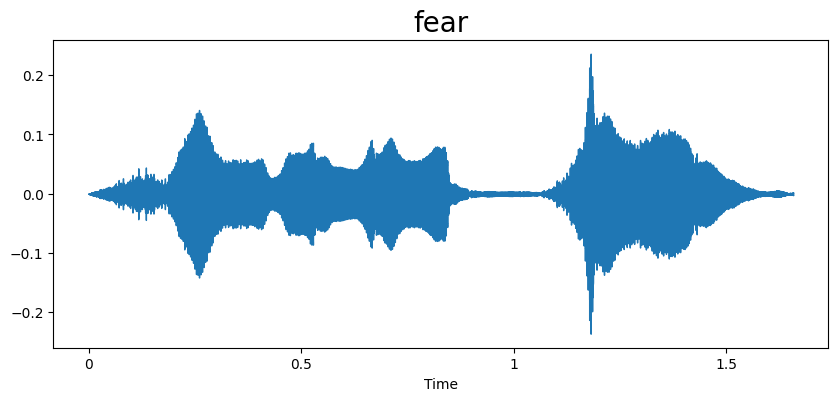

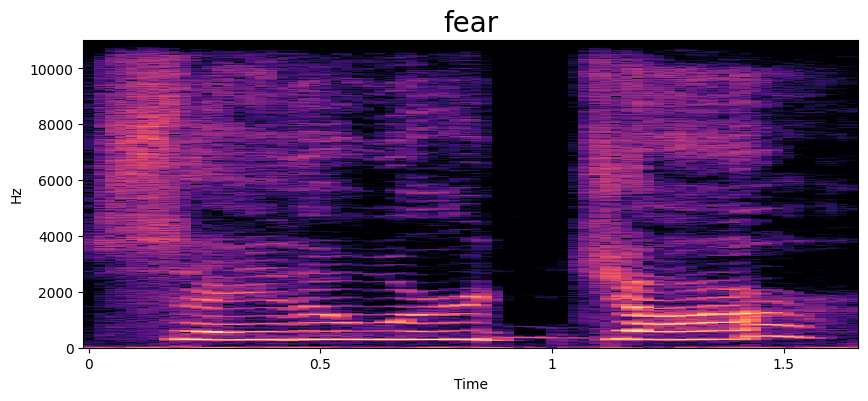

In [11]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

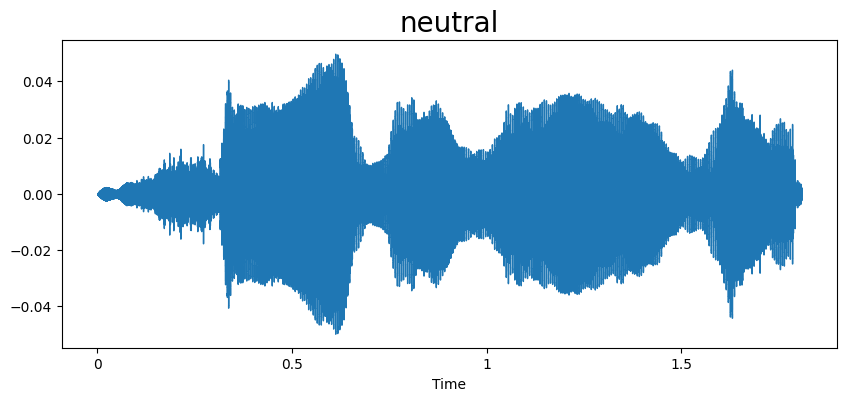

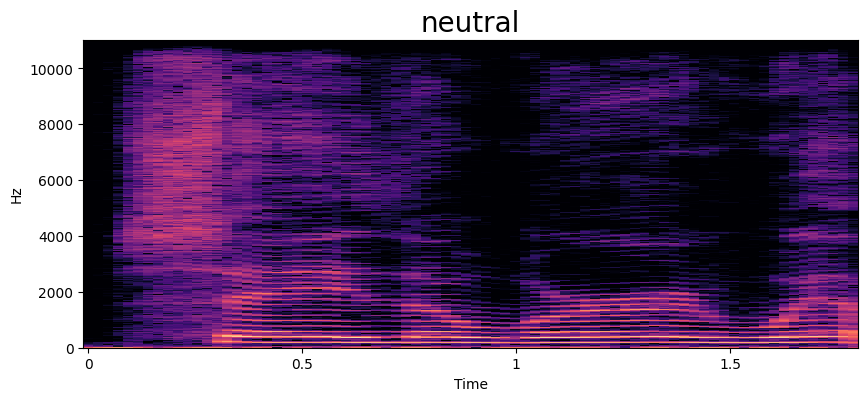

In [12]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [13]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc=np.mean(librosa.feature.mfcc(y=y, sr = sr, n_mfcc=40).T, axis=0)
    return mfcc

In [14]:
x_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [15]:
x_mfcc[0]

array([-3.5238358e+02,  5.5559113e+01,  7.5185341e-01, -4.8541770e+00,
       -2.6867487e+01, -2.7805092e+00, -9.7070509e-01, -1.4188592e+01,
       -1.0599286e+01,  4.9109669e+00, -1.1830047e+01, -2.9117899e+00,
       -3.2160561e+00,  8.4186935e+00,  1.4472446e-02,  5.0045156e+00,
        2.5489006e+00,  6.4610128e+00,  3.6291919e+00,  4.7804980e+00,
       -2.0742240e+00,  5.6261997e+00, -1.2951452e-01,  5.0121617e+00,
       -3.4908807e+00,  1.7945021e+00, -7.9154253e-01, -5.3255129e-01,
        2.6129334e+00,  8.9365063e+00,  6.6709085e+00,  1.4654839e+01,
        3.0140851e+00,  6.8619437e+00,  3.8680120e+00,  4.3522763e+00,
        2.5630219e+00,  3.8649793e+00,  3.2444773e+00,  4.2639141e+00],
      dtype=float32)

In [16]:
X= [x for x in x_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [17]:
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [18]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [19]:
y = y.toarray()
y.shape

(2800, 7)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(123, return_sequences = False, input_shape=(40, 1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(7, activation='softmax'),

])

model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 123)                 │          61,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,747 (280.26 KB)

 Trainable params: 71,747 (280.26 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history=model.fit(X, y, validation_split=0.2, epochs=100, batch_size=64, shuffle = True)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.2887 - loss: 1.6942 - val_accuracy: 0.0018 - val_loss: 3.4211
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7190 - loss: 0.7624 - val_accuracy: 0.3054 - val_loss: 2.9784
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8960 - loss: 0.3336 - val_accuracy: 0.2804 - val_loss: 3.7242
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9383 - loss: 0.2148 - val_accuracy: 0.3089 - val_loss: 3.6607
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9560 - loss: 0.1407 - val_accuracy: 0.4000 - val_loss: 3.1328
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9406 - loss: 0.1845 - val_accuracy: 0.3643 - val_loss: 3.3903
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9724 - loss: 0.0948 - val_accuracy: 0.3929 - val_loss: 3.3063
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9816 - loss: 0.0857 - val_accuracy: 0.

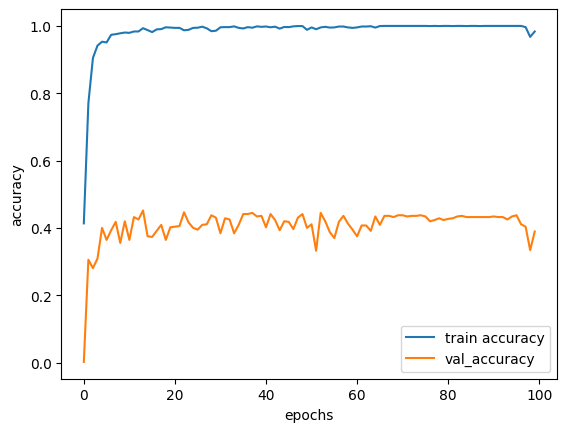

In [24]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label = 'train accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()